In [9]:
using ExpandLGF
using ExpandLGF: inner_integral_expansion_coeffs, inner_integral_expansion, inner_integral_errors
using QuadGK
using PyPlot

Evaluate the convergence of the outer integral computed via series expansion. The integral is defined via
\begin{equation}
    G_{[T_1,\,T_2]}(n) = \int_{T_1}^{T_2} I_{\sigma, n_1}(t) \, I_{\sigma, n_2}(t) \, I_{\sigma, n_3}(t) \,\mathrm{d}t
\end{equation}
and approximated with a series of the form
\begin{equation}
G_{[T,\,\infty]}(\bm{n}) = \frac{1}{4\pi} \sum_{j=1}^m g_j(\bm{n}) T^{-k} + \mathcal{O}\left( T^{-(m+1)} \right),
\end{equation}
where each $g_j(\bm{n})$ is a multivariate polynomial of degree $2j$.|

To test convergence, the integral $G_{[T_1,\,T_2]}(n)$ is evaluated with varying $T_1$ and an upper bound $T_2$ that scales with $T_1$. The error in computing $G_{[T_1,\,T_2]}(n)$ via series expanion is then dominated by the error of truncating the series expansion of $G_{[T_1,\,\infty]}(n)$. This error converges with power law scaling as $T_1$ increases.

In [10]:
###
# Parameters
###
order = 4
stencil = StandardDifference3D(order)
T1 = exp10.(1.0:0.2:7.0)
T2 = 1.0e6 * T1
n = [16, 16, 16]
max_terms = 12

12

In [11]:
###
# Function to evaluate the inner integral
###
inner_terms = 12
inner_coeffs = inner_integral_expansion_coeffs(stencil, inner_terms)
inner_thresh = inner_integral_errors(inner_coeffs, maximum(abs, n))
inner_expansion = ExpandLGF.inner_integral_expansion(inner_coeffs)

function inner_integral(n, t)
    if t > inner_thresh
        return inner_expansion(n, t)
    else
        return ExpandLGF.inner_integral_quad(stencil, n, t)
    end
end

inner_integral (generic function with 1 method)

In [12]:
###
# Evaluate the outer integral numerically
###
function outer_integral_numerical(n, T1, T2; rtol = 1e-14, atol = 1e-15)
    
    integrand(t) = inner_integral(n[1], t) *
                   inner_integral(n[2], t) *
                   inner_integral(n[3], t)

    integral, error = quadgk(integrand, T1, T2; rtol = rtol, atol = atol, order=21)
    return integral
end

numerical_values = [outer_integral_numerical(n, t1, t2) for (t1, t2) in zip(T1, T2)];

In [13]:
###
# Evaluate the outer integral via series expansion
###
analytical_values = Vector{Float64}[]

for terms = 1:max_terms
    outer_expansion = ExpandLGF.outer_integral_expansion(stencil, terms)
    outer_integral(n, t1, t2) = outer_expansion(n, t1) - outer_expansion(n, t2)
    push!(analytical_values, [outer_integral(n, t1, t2) for (t1, t2) in zip(T1, T2)])
end

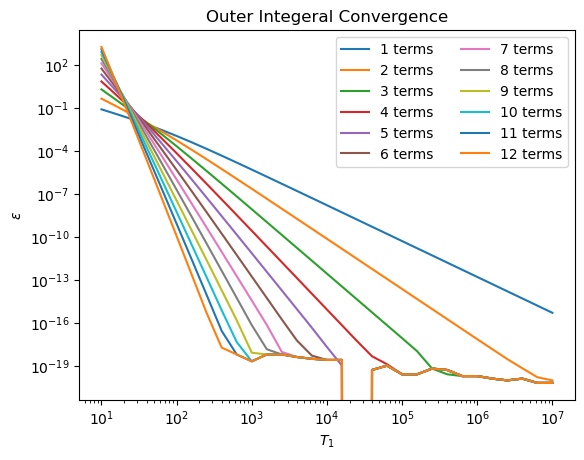

PyObject <matplotlib.legend.Legend object at 0x2a7035880>

In [15]:
###
# Plot the convergence
###

fig, ax = subplots()

for terms = 1:max_terms
    error = abs.(numerical_values - analytical_values[terms])
    ax.loglog(T1, error, label = string(terms) * " terms")
end

ax.set_title("Outer Integeral Convergence")
ax.set_xlabel(L"T_1")
ax.set_ylabel(L"\epsilon")
ax.legend(ncol = 2)